# MBTI - 16 Personalities classifier
**Author:** Eduardo Rinaldi

**Author email:** rinaldi.1797800@studenti.uniroma1.it

**Notebook info:** Big Data Computing (`@ Sapienza University of Rome, A.Y. 2020-2021`) course project



# Introduction to the problem
Design and implement a model that given a collection of "posts" as input returns the most suited **Myers-Briggs personality type indicator (MBTI)** for posts' author.

## What is a **MBTI**
The MBTI (Myers-Briggs Personality Type Indicator) divides everyone into **16 distinct personality** types across **4 axis**:

* Introversion (**I**) – Extroversion (**E**)
* Intuition (**N**) – Sensing (**S**)
* Thinking (**T**) – Feeling (**F**)
* Judging (**J**) – Perceiving (**P**)

This system is used in: *businesses, online, for fun, for research and lots more*.

# Google Colab setup
This part of code is needed if this notebook is "hosted" on a G. Colab's cluster.


1.   Mount G. Drive
2.   Downloading and configuring required libraries (PySpark, SparkNLP, Pandas, Numpy, Tweety, ...)



In [130]:
# Mounting Drive
import colab_env
from google.colab import drive
MOUNT_DIR = '/content/drive/'
drive.mount(MOUNT_DIR, force_remount=True)

# Some constants
USING_COLAB = True

Mounted at /content/drive/


In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash
!pip install pandas
!pip install matplotlib
!pip install git+https://github.com/tweepy/tweepy.git
!pip install colab-env

--2021-07-04 12:20:06--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-07-04 12:20:07--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-07-04 12:20:07 (44.9 MB/s) - written to stdout [1608/1608]

setup Cola

# Databricks setup

This part of code is needed if this notebook is "hosted" on a Databricks' cluster.

1.   Just setting a boolean flag so that from now on we know if we're on Colab or Databricks
2. You need to go on `Cluster settings` and:
  *   Install through *PyPI* `spark-nlp==3.1.0`
  *   Add `com.johnsnowlabs.nlp:spark-nlp_2.12:3.1.0` to *Maven*









In [ ]:
USING_COLAB = False

# Importing Spark (and other things)

In [3]:
import pandas as pd
import numpy as np

# Matplotlib, plt and cm modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn for plotting
import seaborn as sns

# Pritty print
from pprint import pprint

# Twitter API
import tweepy

# for reading .env vars
import os

# PySpark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# SparkNLP, use for text cleaning
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import *

spark = sparknlp.start()
spark

In [146]:
PRETRAINED_MODELS_PATH = '/content/drive/MyDrive/PretrainedModels/' if USING_COLAB else 'dbfs:/FileStore/PretrainedModels/'

# Text cleaning pipeline model
USE_PRETRAINED_TC_PIPELINE = True
PRETRAINED_TC_PIPELINE_NAME = 'tc_pipeline_202107041409'

# Feature Extraction Pipeline Model
USE_PRETRAINED_FE_PIPELINE = True
PRETRAINED_FE_PIPELINE_NAME = 'cv0.01_idf_pca100_202106291739'

# ML Pipeline Models
USE_PRETRAINED_ML_PIPELINE = True
# Naive Bayes
PRETRAINED_NB_PIPELINE_NAMES = {
    'ie': 'nb_ie_modelTypemultinomial_202107031037',
    'ns': 'nb_ns_modelTypemultinomial_202107031037',
    'tf': 'nb_tf_modelTypemultinomial_202107031037',
    'pj': 'nb_pj_modelTypemultinomial_202107031037'
}
# Linear SVC
PRETRAINED_SVC_PIPELINE_NAMES = {
    'ie': 'svc_ie_maxIter10_regParam0.0001_202107031050',
    'ns': 'svc_ns_maxIter10_regParam0.0001_202107031102',
    'tf': 'svc_tf_maxIter10_regParam0.0001_202107031114',
    'pj': 'svc_pj_maxIter10_regParam0.0001_202107031126'
}
# Logistic Regression
PRETRAINED_LR_PIPELINE_NAMES = {
    'ie': 'lr_ie_maxIter10_regParam0.0001_elasticNetParam0.0_202107031200',
    'ns': 'lr_ns_maxIter10_regParam0.0001_elasticNetParam0.25_202107031215',
    'tf': 'lr_tf_maxIter100_regParam0.01_elasticNetParam0.0_202107031229',
    'pj': 'lr_pj_maxIter100_regParam0.0001_elasticNetParam0.0_202107031244'
}
# Neural Network
PRETRAINED_NN_PIPELINE_NAMES = {
    'ie': 'nn_ie_maxIter100_stepSize0.001_solverl-bfgs_202107040909',
    'ns': 'nn_ns_maxIter100_stepSize0.001_solverl-bfgs_202107040933',
    'tf': 'nn_tf_maxIter10_stepSize0.03_solverl-bfgs_202107040957',
    'pj': 'nn_pj_maxIter100_stepSize0.01_solverl-bfgs_202107041020'
}

# Final model
USE_PRETRAINED_FINAL_PIPELINE = True
PRETRAINED_FINAL_PIPELINE = 'final_pipeline_202107041304'

# MBTI Dataset

## Downloading the dataset onto the cluster

I hosted the dataset on my [github](https://github.com/edu-rinaldi/MBTI-Predictor/blob/main/dataset/mbti_1.csv.zip), so that I and whoever want to train a different model can download it in an easier way.

### **Databricks** procedure
Use this part of code **only** if you're on Databricks

In [ ]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

Moving dataset to DBFS

In [ ]:
dbutils.fs.mv("file:/tmp/mbti_1.csv", "/FileStore/datasets/")
MBTI_DATASET_PATH = "dbfs:/FileStore/datasets/mbti_1.csv"

### **Google Colab** procedure
Use this part of code **only** if you're on Colab

In [ ]:
!wget -P /content/drive/MyDrive/datasets/ https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

--2021-07-01 07:52:56--  https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv [following]
--2021-07-01 07:52:56--  https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62856486 (60M) [text/plain]
Saving to: ‘/content/drive/MyDrive/datasets/mbti_1.csv.1’

mbti_1.csv.1        100%[===================>]  59.94M  63.6MB/s    in 0.9s    

2021-07-01 07:52:57 (63.6 MB/s) - ‘/content/drive/MyDrive/datasets

In [5]:
MBTI_DATASET_PATH = "/content/drive/MyDrive/datasets/mbti_1.csv"

## Initial dataset analysis

Now that we have downloaded the dataset, let's read it and analyze it

In [6]:
mbti_df = spark.read.load(MBTI_DATASET_PATH, format="csv", sep=",", inferSchema="true", header="true")
print(f"The dataset is composed by {len(mbti_df.columns)} columns and {mbti_df.count()} entries/records")
mbti_df.show()

The dataset is composed by 2 columns and 8675 entries/records
+----+--------------------+
|type|               posts|
+----+--------------------+
|INFJ|'http://www.youtu...|
|ENTP|'I'm finding the ...|
|INTP|'Good one  _____ ...|
|INTJ|'Dear INTP,   I e...|
|ENTJ|'You're fired.|||...|
|INTJ|'18/37 @.@|||Scie...|
|INFJ|'No, I can't draw...|
|INTJ|'I tend to build ...|
|INFJ|I'm not sure, tha...|
|INTP|'https://www.yout...|
|INFJ|'One time my pare...|
|ENFJ|'https://www.yout...|
|INFJ|'Joe santagato - ...|
|INTJ|'Fair enough, if ...|
|INTP|'Basically this.....|
|INTP|'Your comment scr...|
|INFJ|'some of these bo...|
|INFP|'I think we do ag...|
|INFJ|'I fully believe ...|
|INFP|'That's normal, i...|
+----+--------------------+
only showing top 20 rows



### Description of the dataset
This **dataset** contains over **8600 rows of data**, and on each row contains:
* **Type**: 4 letter MBTI code/type
* **Posts**: A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

So after splitting each post we will have about **430k rows**. 

**Acknowledgements:**
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

### Renaming 'posts' column => 'post' AND lowering 'type' column

In [7]:
#mbti_splitted_df = mbti_df.select(explode(split("posts", "\|\|\|")).alias("post"), lower("type").alias("type"))
mbti_splitted_df = mbti_df.withColumnRenamed('posts', 'post').withColumn('type', lower("type"))
mbti_splitted_df.show()

+----+--------------------+
|type|                post|
+----+--------------------+
|infj|'http://www.youtu...|
|entp|'I'm finding the ...|
|intp|'Good one  _____ ...|
|intj|'Dear INTP,   I e...|
|entj|'You're fired.|||...|
|intj|'18/37 @.@|||Scie...|
|infj|'No, I can't draw...|
|intj|'I tend to build ...|
|infj|I'm not sure, tha...|
|intp|'https://www.yout...|
|infj|'One time my pare...|
|enfj|'https://www.yout...|
|infj|'Joe santagato - ...|
|intj|'Fair enough, if ...|
|intp|'Basically this.....|
|intp|'Your comment scr...|
|infj|'some of these bo...|
|infp|'I think we do ag...|
|infj|'I fully believe ...|
|infp|'That's normal, i...|
+----+--------------------+
only showing top 20 rows



## Are we dealing with a (Un)balanced Dataset ? 
One of the first things to check is the "density" of each class. 
A balanced dataset makes things easier..

### Counting records for each class

In [8]:
def count_class_instances(df, labelCol, toPandas=True):
  counted_df = df.select(labelCol).groupBy(labelCol).count().sort(labelCol)
  return counted_df.toPandas() if toPandas else counted_df

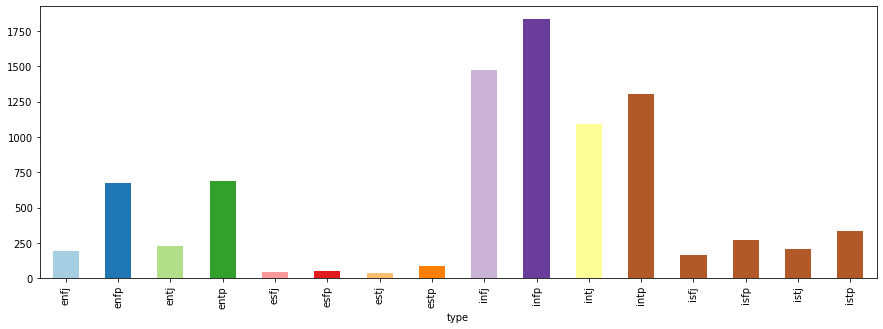

In [ ]:
# Sorting by type because then we could compare this df with another, so bars will have same order
counted_mbti_types_pdf = count_class_instances(mbti_splitted_df, 'type')
counted_mbti_types_pdf.plot.bar(x='type', y='count', figsize=(15,5), legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

The first thing that *unfortunately* we can notice is that the dataset is very **unbalanced**.

The most predominant types are **INxx**, which correspond to introvert personalities; this could mean that on internet (especially on forums and/or social networks) the most predominant personalities are the introvert ones, so in real world application the model could deal more frequently with **INxx** types. 

Another thing to notice is that **Sensing** (**xSxx**) personalities are the less frequents, and that is due to the fact that *Sensors* prefer learning information that they can tangibly apply to their lives (**short description:** they don't like too much internet). 

### Comparing dataset distribution
Let's compare dataset distribution with real world distribution (provided [here](https://personalitymax.com/personality-types/population-gender/))

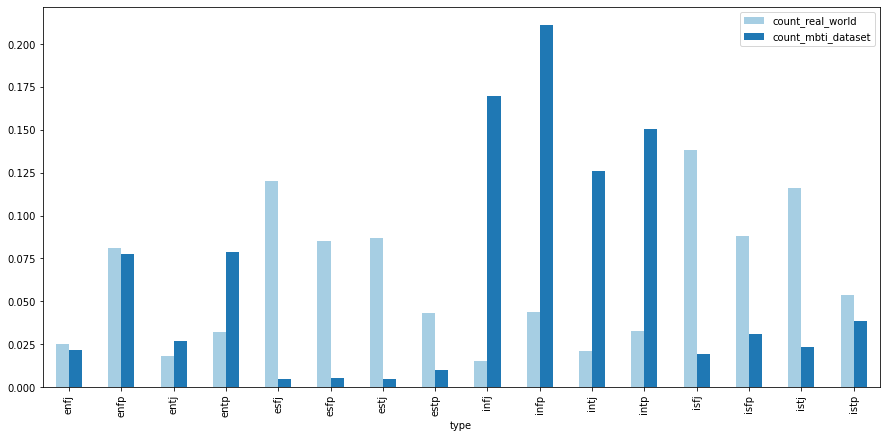

In [ ]:
counted_mbti_types_pdf['count_normalized'] = counted_mbti_types_pdf['count']/counted_mbti_types_pdf['count'].sum()

real_world_pdf = pd.DataFrame({
    'type' : ['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp', 'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
    'count': [0.025, 0.081, 0.018, 0.032, 0.12, 0.085, 0.087, 0.043, 0.015, 0.044, 0.021, 0.033, 0.138, 0.088, 0.116, 0.054]
})
real_world_pdf.head()

pd.DataFrame({
    'type': real_world_pdf['type'],
    'count_real_world': real_world_pdf['count'],
    'count_mbti_dataset': counted_mbti_types_pdf['count_normalized']
}).plot.bar(x='type', figsize=(15, 7), color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

As we can see *"real world"* and *"internet world"* (or dataset) distributions are **very different**. Most **extroverts** are **much "popular"** outside internet, same thing applies for **Sensing** personalities (**xSxx**). 

## Split type in 4 indicators
Dividing type in **4 indicators** *("I/E"*, *"N/S"*, *"T/F"*, *"P/J"*) brings us different benefits:
1. We can create 4 different models (one for each type indicator), so each model could be optimized for its own target (its own type indicator)
2. We can have 4 different datasets, each one with its own different data (or features).
3. We kinda fix "few data" problem for less frequent classes (e.g. *esfp*, *estj*, ..)

So the idea is to have at the end 4 different **Binary Classifiers**, and then we can "merge" their prediction for the "final prediction", but also we can do prediction on only a subset of "type indicators".

In [9]:
def split_type(df, typeCol='type', withDrop=False):
  """
  Given a dataframe and the column containing the type of each record it splits the column 
  in 4 different columns (one for each type indicator):

    1. ie: Introversion vs Extroversion
    2. ns: Intuition vs Sensing
    3. tf: Thinking vs Feeling
    4. pj: Judging vs Perceiving
  
  It returns a pair containing:
    1. Altered dataframe
    2. Indicators columns list

  Parameters
  ----------
  df : pyspark.sql.DataFrame
      Input DataFrame which contains posts
  typeCol : str, optional
      Column where are listed post types. (Default value is 'type')
  withDrop : bool, optional
      If True drop typeCol. (Default value is False)
  """
  indicators = ['ie', 'ns', 'tf', 'pj']
  splitted_type_df = df
  # for each indicator pick the character corresponding to the current indicator and add it to a new column
  for i, ind in enumerate(indicators):
    splitted_type_df = splitted_type_df.withColumn(ind, substring(typeCol, i+1, 1))
  
  # drop typeCol column
  if withDrop:
    splitted_type_df = splitted_type_df.drop(typeCol) 
  
  return splitted_type_df, indicators

In [10]:
# Split type in 4 indicators
mbti_type_splitted_df, indicators = split_type(mbti_splitted_df, withDrop=True)

# mbti_type_splitted_df = mbti_type_splitted_df.cache()
mbti_type_splitted_df.show()

+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|'http://www.youtu...|  i|  n|  f|  j|
|'I'm finding the ...|  e|  n|  t|  p|
|'Good one  _____ ...|  i|  n|  t|  p|
|'Dear INTP,   I e...|  i|  n|  t|  j|
|'You're fired.|||...|  e|  n|  t|  j|
|'18/37 @.@|||Scie...|  i|  n|  t|  j|
|'No, I can't draw...|  i|  n|  f|  j|
|'I tend to build ...|  i|  n|  t|  j|
|I'm not sure, tha...|  i|  n|  f|  j|
|'https://www.yout...|  i|  n|  t|  p|
|'One time my pare...|  i|  n|  f|  j|
|'https://www.yout...|  e|  n|  f|  j|
|'Joe santagato - ...|  i|  n|  f|  j|
|'Fair enough, if ...|  i|  n|  t|  j|
|'Basically this.....|  i|  n|  t|  p|
|'Your comment scr...|  i|  n|  t|  p|
|'some of these bo...|  i|  n|  f|  j|
|'I think we do ag...|  i|  n|  f|  p|
|'I fully believe ...|  i|  n|  f|  j|
|'That's normal, i...|  i|  n|  f|  p|
+--------------------+---+---+---+---+
only showing top 20 rows



### Single type indicator analysis

In [11]:
def plot_indicators_distribution(df):
  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  for ind, subplot in zip(indicators, ax.flatten()):
    sns.histplot(df.toPandas(), x=ind, ax=subplot)

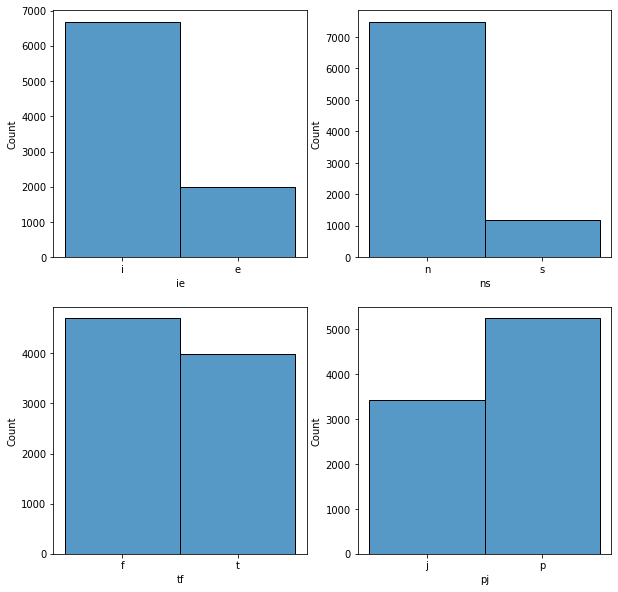

In [ ]:
plot_indicators_distribution(mbti_type_splitted_df)

As we said before the two most unbalanced type indicators are: **"I/E"** and **"N/S"**

# Reddit dataset

For obtaining a model with much more "generalization power" and for increasing the number of data to use for training phase I decided to collect new data and I came up with this new dataset.

## Single post version

It's a **JSONL** dataset containing on each row:
* **Redditor id**: post's author id
* **Post**: contain a single post
* **Text type**: identify if it's a "comment", "title" or a "post"
* **Type**: mbti type associated to the author

This dataset contains XYZ records

## Posts grouped by 'redditor_id'

It's a **PARQUET** dataset containing on each row:
* **Redditor id**: posts' author id
* **Post**: Last things the author posted; each entry is separated by "|||" (w.r.t. Mbti dataset, posts number on each entry ranges from 50 to 100)
* **Text type**: identify if it's a comment, title or a post
* **Type**: as the MBTI dataset

This dataset contains XYZ records

## How data has been collected

Data has been collected on **Reddit** using a scraper created by me (code available [here](https://github.com/edu-rinaldi/MBTI-Predictor/tree/main/scraper)).

First, I collected a list of users (and their personality) in 17 subreddits about MBTI ("r/mbti", "r/infp", ...); the personality information is given by a badge that is assigned to the user (**Reddit API** call it "author flair text").

Then, I've scraped the most recent posts of each user (max. 100 for each user) on the **ENTIRE** Reddit platform, this means that I scraped also posts not related to MBTI universe.

At the end for each post I assigned the badge (so the personality) related to the author.

## Downloading "Post grouped" dataset

### Databricks procedure

In [ ]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz;
tar xvzf /tmp/reddit_mbti.tar.gz -C /tmp/

Move it to DBFS

In [ ]:
# Move it to DBFS
dbutils.fs.mv("file:/tmp/reddit_mbti.parquet", "/FileStore/datasets/")
REDDIT_DATASET_PATH = "dbfs:/FileStore/datasets/reddit_mbti.parquet"

### Google Colab procedure

In [ ]:
!wget -P /content/drive/MyDrive/datasets/ https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz
!tar xvzf /content/drive/MyDrive/datasets/reddit_mbti.tar.gz -C /content/drive/MyDrive/datasets/
!rm /content/drive/MyDrive/datasets/reddit_mbti.tar.gz -r

--2021-07-01 07:54:34--  https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/reddit_mbti.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/reddit_mbti.tar.gz [following]
--2021-07-01 07:54:34--  https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/reddit_mbti.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58116681 (55M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/datasets/reddit_mbti.tar.gz’

reddit_mbti.tar.gz  100%[===================>]  55.42M  81.3MB/s    in 0.7s    

2021-07-01 07:54:36 (8

In [12]:
REDDIT_DATASET_PATH = "/content/drive/MyDrive/datasets/reddit_mbti.parquet"

## Loading dataset into a Spark DataFrame

In [13]:
reddit_df = spark.read.load(REDDIT_DATASET_PATH)
print(f"The dataset is composed by {len(reddit_df.columns)} columns and {reddit_df.count()} records")
reddit_df.show()
# reddit_grouped_df = reddit_df.groupBy('redditor_id', 'type', 'text_type').agg(count(col('redditor_id')).alias('num_post'), concat_ws(" ||| ", collect_list("post")).alias('post')).where(col('num_post') >= 50).cache()

The dataset is composed by 5 columns and 5754 records
+-----------+----+---------+--------+--------------------+
|redditor_id|type|text_type|num_post|                post|
+-----------+----+---------+--------+--------------------+
|     101tuq|intj|  comment|     100|Arin can fred |||...|
|     114fsa|istp|  comment|     100|  ||| "Are you ki...|
|     114fsa|istp|    title|      67|Spin that wheel |...|
|     114mu2|enfp|  comment|     100|Die nerven sich m...|
|     116d0h|enfj|  comment|     100|I admire your abi...|
|   11dxh05w|infp|  comment|     100|👏 but try not to...|
|     11ghzk|isfj|  comment|     100|1: At least 4 stu...|
|     11usaf|istp|  comment|     100|She’s clearly not...|
|     11wn2y|infp|  comment|     100|Yeah, I don’t rea...|
|     12bccu|entp|    title|      50|GAME ENGINE DEVEL...|
|     12j670|entp|  comment|     100|and pink diamond ...|
|     12ryws|entp|  comment|     100|"Just a pam looki...|
|     12u7ez|esfp|  comment|     100|Not gonna lie, I ...|
|  

## Analysis

### Counting records for each type

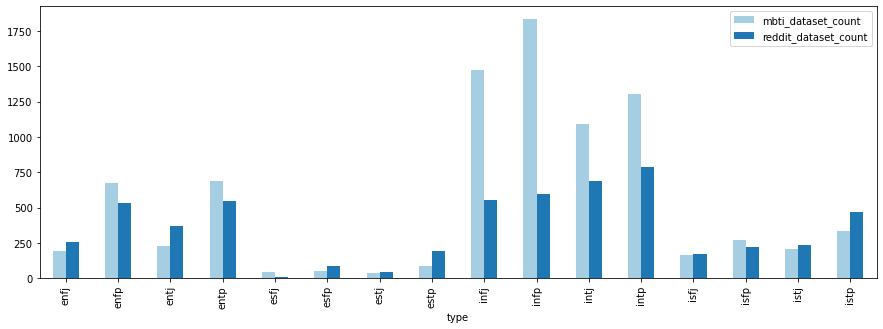

In [ ]:
counted_reddit_types_pdf = count_class_instances(reddit_df, 'type')

pd.DataFrame({
    'mbti_dataset_count': counted_mbti_types_pdf['count'],
    'reddit_dataset_count': counted_reddit_types_pdf['count'],
    'type': counted_reddit_types_pdf['type']
}).plot.bar(x='type', figsize=(15,5), color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

As we can see type distributions are very similar, even if grouped reddit dataset is half smaller than "MBTI dataset".

### Split type in 4 indicators

In [14]:
reddit_splitted_df, _ = split_type(reddit_df, withDrop=True)
reddit_splitted_df.show()

+-----------+---------+--------+--------------------+---+---+---+---+
|redditor_id|text_type|num_post|                post| ie| ns| tf| pj|
+-----------+---------+--------+--------------------+---+---+---+---+
|     101tuq|  comment|     100|Arin can fred |||...|  i|  n|  t|  j|
|     114fsa|  comment|     100|  ||| "Are you ki...|  i|  s|  t|  p|
|     114fsa|    title|      67|Spin that wheel |...|  i|  s|  t|  p|
|     114mu2|  comment|     100|Die nerven sich m...|  e|  n|  f|  p|
|     116d0h|  comment|     100|I admire your abi...|  e|  n|  f|  j|
|   11dxh05w|  comment|     100|👏 but try not to...|  i|  n|  f|  p|
|     11ghzk|  comment|     100|1: At least 4 stu...|  i|  s|  f|  j|
|     11usaf|  comment|     100|She’s clearly not...|  i|  s|  t|  p|
|     11wn2y|  comment|     100|Yeah, I don’t rea...|  i|  n|  f|  p|
|     12bccu|    title|      50|GAME ENGINE DEVEL...|  e|  n|  t|  p|
|     12j670|  comment|     100|and pink diamond ...|  e|  n|  t|  p|
|     12ryws|  commen

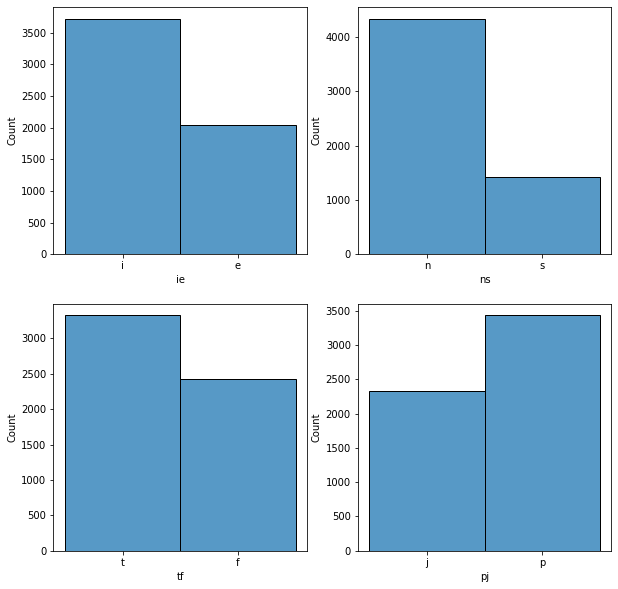

In [ ]:
plot_indicators_distribution(reddit_splitted_df)

# Union of MBTI dataset and Grouped Reddit dataset
Let's merge the two dataset and let's do some further analysis on them

In [15]:
union_df = reddit_splitted_df.select('post', 'ie', 'ns', 'tf', 'pj').union(mbti_type_splitted_df)
print(f"The dataset is composed by {len(union_df.columns)} columns and {union_df.count()} records")
union_df.show()

The dataset is composed by 5 columns and 14429 records
+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|Arin can fred |||...|  i|  n|  t|  j|
|  ||| "Are you ki...|  i|  s|  t|  p|
|Spin that wheel |...|  i|  s|  t|  p|
|Die nerven sich m...|  e|  n|  f|  p|
|I admire your abi...|  e|  n|  f|  j|
|👏 but try not to...|  i|  n|  f|  p|
|1: At least 4 stu...|  i|  s|  f|  j|
|She’s clearly not...|  i|  s|  t|  p|
|Yeah, I don’t rea...|  i|  n|  f|  p|
|GAME ENGINE DEVEL...|  e|  n|  t|  p|
|and pink diamond ...|  e|  n|  t|  p|
|"Just a pam looki...|  e|  n|  t|  p|
|Not gonna lie, I ...|  e|  s|  f|  p|
|What the fuck is ...|  e|  s|  f|  p|
|Please supply mor...|  e|  n|  t|  j|
|Why can't you guy...|  e|  n|  t|  j|
|Radio killed the ...|  e|  n|  f|  p|
|I'm actually Turb...|  i|  n|  t|  p|
|Ecuador says hack...|  i|  n|  f|  j|
|This applies to V...|  i|  n|  t|  p|
+--------------------+---+---+---+---+
only showi

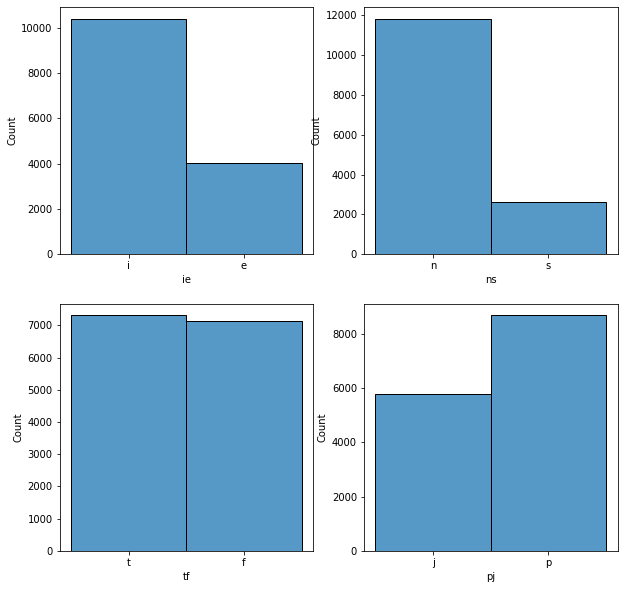

In [ ]:
plot_indicators_distribution(union_df)

# Data/Text cleaning
Before creating a balanced dataset let's first clean them (some records will be removed, so it's better to balance after)

## Cleaning MBTI dataset

In [18]:
def save_model(model, name):
  import datetime
  path = PRETRAINED_MODELS_PATH + name + f'_{datetime.datetime.now().strftime("%Y%m%d%H%M")}'
  print(f'Saving the model at this path: {path}')
  model.write().overwrite().save(path)

In [155]:
def text_cleaning_pipeline(df, inputCol='post', outputCol='terms', saveModel=False):
  
  normalization_patterns = [
    '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]' + \
    '[a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', # url
    ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)', #emoticons
    '(\[removed\])',  # removed reddit instance
    '[^A-Za-z]',
    '([ieIE])([nsNS])([tfTF])([pjPJ])', # remove mbti words
    '([a-z])\1{2,}[\s|\w]*' # remove consecutive single chars
  ]
  
  documentAssembler = DocumentAssembler()\
    .setInputCol(inputCol)\
    .setOutputCol('document')\
    #.setCleanupMode("shrink_full")
  
  tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
  
  normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized')\
    .setLowercase(True)\
    .setCleanupPatterns(normalization_patterns) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
  
  lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \
    #.setDictionary("dbfs:/bdc-2020-21/lemmatizer_files/lemmas.txt", value_delimiter ="\t", key_delimiter = "->")
  
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_en', 'en')\
      .setInputCols('lemma')\
      .setOutputCol('cleanLemma_1')\
      .setCaseSensitive(False)

  second_stopwords_cleaner = StopWordsCleaner()\
      .setInputCols('cleanLemma_1')\
      .setOutputCol('cleanLemma_2')\
      .setCaseSensitive(False)\
      .setStopWords(['isnt', 'dont', 'ive', 'im', 'arent', 'doesnt', 'havent', 'youre'])
  
  finisher = Finisher() \
    .setInputCols(['cleanLemma_2']) \
    .setOutputCols([outputCol]) \
    .setIncludeMetadata(False)
  
  pipeline_stages = [
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    second_stopwords_cleaner,
    finisher
  ]

  tc_pipeline_model = Pipeline(stages=pipeline_stages).fit(df)

  if saveModel:
    save_model(tc_pipeline_model, 'tc_pipeline')

  return tc_pipeline_model

In [158]:
# train/test splitting
train_df, test_df = union_df.randomSplit([0.7, 0.3])
train_df = train_df.cache()
test_df = test_df.cache()

# tc_pipeline will be used for cleaning and splitting in terms posts
if USE_PRETRAINED_TC_PIPELINE:
  print(f'Using pretrained text cleaning pipeline model: {PRETRAINED_TC_PIPELINE_NAME}')
  tc_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_TC_PIPELINE_NAME)
else:
  print('Fitting new text cleaning pipeline')
  tc_pipeline = text_cleaning_pipeline(train_df, saveModel=True)

clean_train_df = tc_pipeline.transform(train_df)
clean_test_df = tc_pipeline.transform(test_df)

Using pretrained text cleaning pipeline model: tc_pipeline_202107041409


In [153]:
def feature_extraction_pipeline(df,
                                termsCol='terms',
                                outputCVFeaturesCol='cv_features',
                                cvVocabSize=262144,
                                outputIdfFeaturesCol='idf_features',
                                outputPCAFeaturesCol='pca_features',
                                pcaK=100,
                                cvMinDF=0.01,
                                indicatorsCols=['ie','ns','tf','pj'],
                                pretrainedName='',
                                saveModel=False):
  from pyspark.ml.feature import CountVectorizer, IDF, PCA, StringIndexer
  from pyspark.ml import Pipeline, PipelineModel
  
  if pretrainedName != '':
    pipeline_model = PipelineModel.load(PRETRAINED_MODELS_PATH+pretrainedName)
    print(f'Using a pretrained pipeline model saved at this path: {pretrainedName}')
  else:
    print('Creating a new pipeline model')
    cv = CountVectorizer(inputCol=termsCol, outputCol=outputCVFeaturesCol, minDF=cvMinDF, vocabSize=cvVocabSize)
    idf = IDF(inputCol=outputCVFeaturesCol, outputCol=outputIdfFeaturesCol)
    pca = PCA(k=100, inputCol=outputIdfFeaturesCol, outputCol=outputPCAFeaturesCol)
    string_indexers = [StringIndexer(inputCol=ind, outputCol=f"idx_{ind}") for ind in indicators]
    stages = [cv, idf] + ([pca] if pcaK > 0 else []) + string_indexers
    pipeline_model = Pipeline(stages=stages).fit(df)
    print('Fitting the new pipeline model')
  
  if saveModel:
    tmp_pca_str = f'pca{pcaK}_' if pcaK > 0 else ''
    save_path = f'cv{cvMinDF}_idf_{tmp_pca_str}'
    save_model(pipeline_model, save_path)
  
  return pipeline_model

In [20]:
fe_pipeline = feature_extraction_pipeline(clean_train_df, pretrainedName=PRETRAINED_FE_PIPELINE_NAME if USE_PRETRAINED_FE_PIPELINE else '')
labels = [fe_pipeline.stages[3+i].labels for i, ind in enumerate(indicators)]

fe_pipeline.transform(clean_train_df).show()

Using a pretrained pipeline model saved at this path: cv0.01_idf_pca100_202106291739
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|                post| ie| ns| tf| pj|               terms|         cv_features|        idf_features|        pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
|

-I love it how ...|  i|  n|  t|  j|[love, officially...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0312529531246...|   0.0|   0.0|   0.0|   1.0|
|
I just moved int...|  i|  n|  t|  j|[move, apartment,...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0047364548986...|   0.0|   0.0|   0.0|   1.0|
|  ||| "Are you ki...|  i|  s|  t|  p|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0117535358123...|   0.0|   1.0|   0.0|   0.0|
| "riding

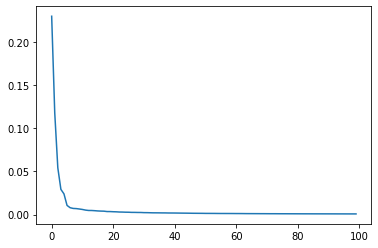

In [ ]:
# Explained Variance by PCA (from ~20 not so much variance)
plt.plot(fe_pipeline.stages[2].explainedVariance)

In [21]:
final_train_df = fe_pipeline.transform(clean_train_df).cache()
final_test_df = fe_pipeline.transform(clean_test_df).cache()

In [22]:
def ml_pipeline(df,
                trainingAlgorithm,
                paramGrid,
                evaluator,
                labels,
                kFold=4,
                featuresCol='features',
                indexedTargetCol='idx_target',
                predictionCol='prediction',
                rawPredictionCol='rawPrediction',
                labeledPredictionCol='labeled_prediction', 
                metricName='f1'):
  
  from pyspark.ml.feature import IndexToString
  from pyspark.ml.tuning import CrossValidator
  from pyspark.ml import Pipeline
  
  trainingAlgorithm = trainingAlgorithm.setFeaturesCol(featuresCol).setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setRawPredictionCol(rawPredictionCol)
  
  idx2str = IndexToString(inputCol=predictionCol,
                          outputCol=labeledPredictionCol,
                          labels=labels)
  
  ml_pipeline = Pipeline(stages=[trainingAlgorithm, idx2str])
  
  evaluator = evaluator.setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setMetricName(metricName)
  
  return CrossValidator(estimator=ml_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=kFold, collectSubModels=True).fit(df)

In [48]:
best_models = {ind:{} for ind in indicators}

# Naive Bayes Classifier

In [24]:
def nb_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import NaiveBayes
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  best_nb_models = dict()

  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best NB model for {ind} type indicator..\n')
    nb_classifier = NaiveBayes()
    nb_param_grid = ParamGridBuilder().addGrid(nb_classifier.modelType, ['multinomial', 'gaussian']).build()
    nb_evaluator = MulticlassClassificationEvaluator()
    cv_model = ml_pipeline(final_train_df,
                           nb_classifier,
                           nb_param_grid,
                           nb_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}', 
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)
    best_nb_models[ind] = cv_model.bestModel    
    if saveModel:
      import builtins
      save_model(best_nb_models[ind], f'nb_{ind}_modelType{best_nb_models[ind].stages[0].getModelType()}')

    print(f'Best nb {ind} model has type {best_nb_models[ind].stages[0].getModelType()}\n')

  return best_nb_models

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NB pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NB_PIPELINE_NAMES.items()}
else:
  tmp = nb_model_tuning(final_train_df, labels, featuresCol='idf_features')

for ind in indicators:
  evaluator = MulticlassClassificationEvaluator(predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}', metricName='f1')
  best_models[ind]['nb'] = (tmp[ind], evaluator.evaluate(tmp[ind].transform(final_test_df)))

pprint(best_models)

Loading pretrained NB pipeline


{'ie': {'nb': (PipelineModel_d63f43b02ed4, 0.719864776814669)},
 'ns': {'nb': (PipelineModel_ed93fdb8001d, 0.7772313730481906)},
 'pj': {'nb': (PipelineModel_58af196f2fba, 0.6666928564595915)},
 'tf': {'nb': (PipelineModel_1f0328671510, 0.7351065178889857)}}

# Linear SVC

In [26]:
def svc_model_tuning(df,
                     labels,
                     kFold=4,
                     allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                     featuresCol='features',
                     saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import LinearSVC
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  best_svc_models = dict()

  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best SVC model for {ind} type indicator..\n')
    svc_classifier = LinearSVC()
    svc_param_grid = ParamGridBuilder().addGrid(svc_classifier.maxIter, [10, 100]) \
    .addGrid(svc_classifier.regParam, [1, 0.5, 0.1, 0.01, 0.001, 0.0001]).build()
    
    svc_evaluator = MulticlassClassificationEvaluator()
    cv_model = ml_pipeline(final_train_df,
                           svc_classifier,
                           svc_param_grid,
                           svc_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)

    best_svc_models[ind] = cv_model.bestModel
    
    if saveModel:
      import builtins
      save_model(best_svc_models[ind], f'svc_{ind}_maxIter{best_svc_models[ind].stages[0].getMaxIter()}_regParam{best_svc_models[ind].stages[0].getRegParam()}')
    
    print(f'Best svc {ind} model has parameters:\n\t - maxIter: {best_svc_models[ind].stages[0].getMaxIter()}\n\t - regParam: {best_svc_models[ind].stages[0].getRegParam()}\n')
  
  return best_svc_models

In [50]:
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained SVC pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_SVC_PIPELINE_NAMES.items()}
else:
  tmp = svc_model_tuning(final_train_df, labels, featuresCol='pca_features')

for ind in indicators:
  evaluator = MulticlassClassificationEvaluator(predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}', metricName='f1')
  best_models[ind]['svc'] = (tmp[ind], evaluator.evaluate(tmp[ind].transform(final_test_df)))

pprint(best_models)

Loading pretrained SVC pipeline


{'ie': {'nb': (PipelineModel_d63f43b02ed4, 0.719864776814669),
  'svc': (PipelineModel_59bff8ef4426, 0.6075519108373931)},
 'ns': {'nb': (PipelineModel_ed93fdb8001d, 0.7772313730481906),
  'svc': (PipelineModel_cef483fee89b, 0.7429296873908131)},
 'pj': {'nb': (PipelineModel_58af196f2fba, 0.6666928564595915),
  'svc': (PipelineModel_129dd968e4f7, 0.517500964281906)},
 'tf': {'nb': (PipelineModel_1f0328671510, 0.7351065178889857),
  'svc': (PipelineModel_af4274f256f5, 0.7316229167621461)}}

# Logistic Regression

In [28]:
def lr_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder, CrossValidatorModel
  from pyspark.ml.classification import LogisticRegression
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  best_lr_models = dict()
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best LR model for {ind} type indicator..\n')
    lr_classifier = LogisticRegression(probabilityCol=f'{ind}_p')
    lr_param_grid = ParamGridBuilder().addGrid(lr_classifier.maxIter, [10, 100]) \
    .addGrid(lr_classifier.regParam, [0.05, 0.01, 0.001, 0.0005, 0.0001]) \
    .addGrid(lr_classifier.elasticNetParam, [0.0, 0.25, 0.5]).build()
    
    lr_evaluator = MulticlassClassificationEvaluator()
    cv_model = ml_pipeline(final_train_df,
                           lr_classifier,
                           lr_param_grid,
                           lr_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)


    best_lr_models[ind] = cv_model.bestModel
    
    if saveModel:
      import builtins
      save_model(best_lr_models[ind], f'cv_lr_{ind}_maxIter{best_lr_models[ind].stages[0].getMaxIter()}_regParam{best_lr_models[ind].stages[0].getRegParam()}_elasticNetParam{best_lr_models[ind].stages[0].getElasticNetParam()}')
      
    print(f'Best LR {ind} model has parameters:\n\t - maxIter: {best_lr_models[ind].stages[0].getMaxIter()}\n\t - regParam: {best_lr_models[ind].stages[0].getRegParam()}\n\t - elasticNetParam: {best_lr_models[ind].stages[0].getElasticNetParam()}\n')
  return best_lr_models

In [51]:
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained LR pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_LR_PIPELINE_NAMES.items()}
else:
  tmp = lr_model_tuning(final_train_df, labels, featuresCol='pca_features')

for ind in indicators:
  evaluator = MulticlassClassificationEvaluator(predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}', metricName='f1')
  best_models[ind]['lr'] = (tmp[ind], evaluator.evaluate(tmp[ind].transform(final_test_df)))

pprint(best_models)

Loading pretrained LR pipeline


{'ie': {'lr': (PipelineModel_5b7ccb054f11, 0.6486812664082684),
  'nb': (PipelineModel_d63f43b02ed4, 0.719864776814669),
  'svc': (PipelineModel_59bff8ef4426, 0.6075519108373931)},
 'ns': {'lr': (PipelineModel_797bed824b69, 0.7613852560290469),
  'nb': (PipelineModel_ed93fdb8001d, 0.7772313730481906),
  'svc': (PipelineModel_cef483fee89b, 0.7429296873908131)},
 'pj': {'lr': (PipelineModel_848a3bad8cbc, 0.5708854010865502),
  'nb': (PipelineModel_58af196f2fba, 0.6666928564595915),
  'svc': (PipelineModel_129dd968e4f7, 0.517500964281906)},
 'tf': {'lr': (PipelineModel_a522529c3398, 0.7320387225322149),
  'nb': (PipelineModel_1f0328671510, 0.7351065178889857),
  'svc': (PipelineModel_af4274f256f5, 0.7316229167621461)}}

# MLP

In [30]:
def nn_model_tuning(df,
                    labels,
                    kFold=4,
                    allowed_indicators=['ie', 'ns', 'tf', 'pj'],
                    featuresCol='features',
                    inputLayerSize=128,
                    pretrainedNames={},
                    saveModel=True):
  
  from pyspark.ml.tuning import ParamGridBuilder
  from pyspark.ml.classification import MultilayerPerceptronClassifier
  from pyspark.ml.tuning import CrossValidatorModel
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  NN_LAYERS = [
               [inputLayerSize, 32, 16, 2],
               [inputLayerSize, inputLayerSize*2, inputLayerSize*2, inputLayerSize, 32, 16, 2],
               # [inputLayerSize, inputLayerSize*3, inputLayerSize*2, 2]
               ]

  best_nn_models = dict()
  for i, ind in enumerate(allowed_indicators):
    print(f'Finding best NN model for {ind} type indicator..\n')
    nn_classifier = MultilayerPerceptronClassifier(probabilityCol=f'{ind}_p')
    nn_param_grid = ParamGridBuilder().addGrid(nn_classifier.maxIter, [10, 100]) \
    .addGrid(nn_classifier.stepSize, [0.03, 0.01, 0.001]) \
    .addGrid(nn_classifier.solver, ['gd', 'l-bfgs']) \
    .addGrid(nn_classifier.layers, NN_LAYERS).build()
    
    nn_evaluator = MulticlassClassificationEvaluator()
    cv_model = ml_pipeline(final_train_df,
                           nn_classifier,
                           nn_param_grid,
                           nn_evaluator,
                           labels[i],
                           featuresCol=featuresCol,
                           indexedTargetCol=f'idx_{ind}',
                           predictionCol=f'{ind}_pred',
                           rawPredictionCol=f'{ind}_raw_pred',
                           labeledPredictionCol=f'{ind}_labeled_pred',
                           kFold=kFold)

    best_nn_models[ind] = cv_model.bestModel
    if saveModel:
      import builtins
      save_model(best_nn_models[ind], f'nn_{ind}_maxIter{best_nn_models[ind].stages[0].getMaxIter()}_stepSize{best_nn_models[ind].stages[0].getStepSize()}_solver{best_nn_models[ind].stages[0].getSolver()}')
    
    print(f'Best NN {ind} model has parameters:\n\t'+ \
        f' - maxIter: {best_nn_models[ind].stages[0].getMaxIter()}\n\t'+ \
        f' - stepSize: {best_nn_models[ind].stages[0].getStepSize()}\n\t'+ \
        f' - solver: {best_nn_models[ind].stages[0].getSolver()}\n\t'+ \
        f' - layers: {best_nn_models[ind].stages[0].getLayers()}\n')
  return best_nn_models

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
if USE_PRETRAINED_ML_PIPELINE:
  print("Loading pretrained NN pipeline")
  tmp = {ind: PipelineModel.load(PRETRAINED_MODELS_PATH+name) for ind, name in PRETRAINED_NN_PIPELINE_NAMES.items()}
else:
  tmp = nn_model_tuning(final_train_df, labels, featuresCol='pca_features', inputLayerSize=100)

for ind in indicators:
  evaluator = MulticlassClassificationEvaluator(predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}', metricName='f1')
  best_models[ind]['nn'] = (tmp[ind], evaluator.evaluate(tmp[ind].transform(final_test_df)))

pprint(best_models)

Loading pretrained NN pipeline


{'ie': {'lr': (PipelineModel_5b7ccb054f11, 0.6486812664082684),
  'nb': (PipelineModel_d63f43b02ed4, 0.719864776814669),
  'nn': (PipelineModel_a968a6bb2050, 0.7235216640689741),
  'svc': (PipelineModel_59bff8ef4426, 0.6075519108373931)},
 'ns': {'lr': (PipelineModel_797bed824b69, 0.7613852560290469),
  'nb': (PipelineModel_ed93fdb8001d, 0.7772313730481906),
  'nn': (PipelineModel_56434233d098, 0.8409627311804302),
  'svc': (PipelineModel_cef483fee89b, 0.7429296873908131)},
 'pj': {'lr': (PipelineModel_848a3bad8cbc, 0.5708854010865502),
  'nb': (PipelineModel_58af196f2fba, 0.6666928564595915),
  'nn': (PipelineModel_2cb6410bbcb3, 0.7165511258027906),
  'svc': (PipelineModel_129dd968e4f7, 0.517500964281906)},
 'tf': {'lr': (PipelineModel_a522529c3398, 0.7320387225322149),
  'nb': (PipelineModel_1f0328671510, 0.7351065178889857),
  'nn': (PipelineModel_10034260e868, 0.6880388699784412),
  'svc': (PipelineModel_af4274f256f5, 0.7316229167621461)}}

# Pick best models

In [150]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

final_models = dict()
for ind in indicators:
  best_score = 0
  best_model_type = -1
  for model_type, (model, score) in best_models[ind].items():
    if best_score < score:
      best_score = score
      best_model_type = model_type
    print(f'Model {model_type} score = {score}')
  final_models[ind] = best_models[ind][best_model_type][0]
  print(f'Best {ind} model is {best_model_type} with score = {best_score}\n')
  

pprint(final_models)

Model nb score = 0.719864776814669
Model svc score = 0.6075519108373931
Model lr score = 0.6486812664082684
Model nn score = 0.7235216640689741
Best ie model is nn with score = 0.7235216640689741

Model nb score = 0.7772313730481906
Model svc score = 0.7429296873908131
Model lr score = 0.7613852560290469
Model nn score = 0.8409627311804302
Best ns model is nn with score = 0.8409627311804302

Model nb score = 0.7351065178889857
Model svc score = 0.7316229167621461
Model lr score = 0.7320387225322149
Model nn score = 0.6880388699784412
Best tf model is nb with score = 0.7351065178889857

Model nb score = 0.6666928564595915
Model svc score = 0.517500964281906
Model lr score = 0.5708854010865502
Model nn score = 0.7165511258027906
Best pj model is nn with score = 0.7165511258027906

{'ie': PipelineModel_a968a6bb2050,
 'ns': PipelineModel_56434233d098,
 'pj': PipelineModel_2cb6410bbcb3,
 'tf': PipelineModel_1f0328671510}


In [54]:
def merge_models(models, saveMergedModel=False, nameMergedModel=''):
  print(models)
  stages = []
  for model in models:
    stages += model.stages
  merged_model = PipelineModel(stages=stages)
  print(merged_model)
  # save merged model
  if saveMergedModel:
    model_name = 'model' if nameMergedModel == '' else nameMergedModel
    save_model(merged_model, model_name)
  
  return merged_model

In [141]:
if USE_PRETRAINED_FINAL_PIPELINE:
  print('Using a pretrained final model')
  final_model = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_FINAL_PIPELINE)
else:
  print('Merging tc/fe/ml pipelines')
  final_model = merge_models([tc_pipeline, fe_pipeline] + [final_models[ind] for ind in indicators], saveMergedModel=True, nameMergedModel='final_pipeline')

print('Final model stages:')
pprint(final_model.stages)

Using a pretrained final model
Final model stages:
[DocumentAssembler_639e26a38c11,
 REGEX_TOKENIZER_acbcdd8e77a6,
 NORMALIZER_8489caeff015,
 LEMMATIZER_c62ad8f355f9,
 STOPWORDS_CLEANER_3e62acb2648b,
 StopWordsCleaner_a22e6a4e3599,
 Finisher_74c55ed604b5,
 CountVectorizerModel: uid=CountVectorizer_74311f5a9216, vocabularySize=5305,
 IDFModel: uid=IDF_8542f318e886, numDocs=10097, numFeatures=5305,
 PCAModel: uid=PCA_0152f2d93653, k=100,
 StringIndexerModel: uid=StringIndexer_317a7e640ccc, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_f6c7a2bbee12, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_88a49382b8d1, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_4858f2712183, handleInvalid=error,
 MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_ebd506023d8f, numLayers=7, numClasses=2, numFeatures=100,
 IndexToString_8d485bd6f691,
 MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_9c5d7f70fdcd, numLayers

# Predicting from twitter users posts

In [134]:
class MBTIPredictor:
  def __init__(self, model_path):
    self.model = PipelineModel.load(model_path)
  
  def predict(self, *text : str):
    text_df = spark.createDataFrame(list(text), StringType()).withColumnRenamed('value', 'post')
    return self.model.transform(text_df)

class TwitterMBTIPredictor(MBTIPredictor):
  def __init__(self, model_path, consumer_key, consumer_secret):
    super().__init__(model_path)
    self.auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    self.api = tweepy.API(self.auth)

  def predict(self, users, num_of_posts=50):
    tweets = []
    for user in users:
      tweets += [" ||| ".join([tweet.text for tweet in self.api.user_timeline(screen_name=user, count=num_of_posts)])]
    return super().predict(*tweets)

In [135]:
twitter_predictor = TwitterMBTIPredictor('/content/drive/MyDrive/PretrainedModels/final_pipeline_202107041304', 
                                         os.getenv('CONSUMER_KEY'), 
                                         os.getenv('CONSUMER_SECRET'))

In [149]:
twitter_users = ['BarackObama', 'BillGates', 'ConanOBrien']
twitter_predictor.predict(users=twitter_users) \
.select('post', 'terms','ie_labeled_pred', 'ns_labeled_pred', 'tf_labeled_pred', 'pj_labeled_pred') \
.show()

+--------------------+--------------------+---------------+---------------+---------------+---------------+
|                post|               terms|ie_labeled_pred|ns_labeled_pred|tf_labeled_pred|pj_labeled_pred|
+--------------------+--------------------+---------------+---------------+---------------+---------------+
|Happy Fourth of J...|[happy, fourth, j...|              i|              n|              f|              p|
|Stopping Alzheime...|[stop, alzheimers...|              i|              n|              t|              j|
|I’m going to quit...|[quit, day, drink...|              i|              n|              t|              p|
+--------------------+--------------------+---------------+---------------+---------------+---------------+



# Another approach: single post prediction

In [ ]:
""" 
THINGS TO DO TOMORROW:
  1) union_df.split ==> saved version (parquet file)
  2) train FE again with PCA K=100
  3) train NB and NN
  4) show results
OTHERS:
  1) Create an evaluate_model(..) function that print [accuracy, f1, precision, recall]
  2) Use evaluate_model(..) on the collection of posts approach
  3) Try to simplify training code
  4) Pretrained models and datasets must be downloadable from the project
  5) Slides
  6) Increase number of users for twitters prediction
"""

In [171]:
PRETRAINED_MODELS_PATH = '/content/drive/MyDrive/PretrainedModels/' if USING_COLAB else 'dbfs:/FileStore/PretrainedModels/'

# Text cleaning pipeline model
USE_PRETRAINED_TC_PIPELINE = True
PRETRAINED_TC_PIPELINE_NAME = 'tc_pipeline_202107041448'

# Feature Extraction Pipeline Model
USE_PRETRAINED_FE_PIPELINE = True
PRETRAINED_FE_PIPELINE_NAME = 'cv1_idf__202107041540'

# ML Pipeline Models
USE_PRETRAINED_ML_PIPELINE = True
# Naive Bayes
PRETRAINED_NB_PIPELINE_NAMES = {
    'ie': 'nb_ie_modelTypemultinomial_202107031037',
    'ns': 'nb_ns_modelTypemultinomial_202107031037',
    'tf': 'nb_tf_modelTypemultinomial_202107031037',
    'pj': 'nb_pj_modelTypemultinomial_202107031037'
}
# Linear SVC
PRETRAINED_SVC_PIPELINE_NAMES = {
    'ie': 'svc_ie_maxIter10_regParam0.0001_202107031050',
    'ns': 'svc_ns_maxIter10_regParam0.0001_202107031102',
    'tf': 'svc_tf_maxIter10_regParam0.0001_202107031114',
    'pj': 'svc_pj_maxIter10_regParam0.0001_202107031126'
}
# Logistic Regression
PRETRAINED_LR_PIPELINE_NAMES = {
    'ie': 'lr_ie_maxIter10_regParam0.0001_elasticNetParam0.0_202107031200',
    'ns': 'lr_ns_maxIter10_regParam0.0001_elasticNetParam0.25_202107031215',
    'tf': 'lr_tf_maxIter100_regParam0.01_elasticNetParam0.0_202107031229',
    'pj': 'lr_pj_maxIter100_regParam0.0001_elasticNetParam0.0_202107031244'
}
# Neural Network
PRETRAINED_NN_PIPELINE_NAMES = {
    'ie': 'nn_ie_maxIter100_stepSize0.001_solverl-bfgs_202107040909',
    'ns': 'nn_ns_maxIter100_stepSize0.001_solverl-bfgs_202107040933',
    'tf': 'nn_tf_maxIter10_stepSize0.03_solverl-bfgs_202107040957',
    'pj': 'nn_pj_maxIter100_stepSize0.01_solverl-bfgs_202107041020'
}

# Final model
USE_PRETRAINED_FINAL_PIPELINE = True
PRETRAINED_FINAL_PIPELINE = 'final_pipeline_202107041304'

In [152]:
single_post_df = union_df.withColumn('post', explode(split("post", "\|\|\|")))
print(f'Now we have a new dataset with {single_post_df.columns} columns and {single_post_df.count()} records')
single_post_df.show()

Now we have a new dataset with ['post', 'ie', 'ns', 'tf', 'pj'] columns and 951629 records
+--------------------+---+---+---+---+
|                post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
|      Arin can fred |  i|  n|  t|  j|
| You know, it's f...|  i|  n|  t|  j|
| Meanwhile I'm dy...|  i|  n|  t|  j|
| Especially with ...|  i|  n|  t|  j|
| What? Is this a ...|  i|  n|  t|  j|
| Ja, og de var va...|  i|  n|  t|  j|
| Norwegian here. ...|  i|  n|  t|  j|
| I love it. Can't...|  i|  n|  t|  j|
|             Whohoo |  i|  n|  t|  j|
| ISTJ - Accountin...|  i|  n|  t|  j|
| I think ISTJ's b...|  i|  n|  t|  j|
| I think the most...|  i|  n|  t|  j|
| All talks machin...|  i|  n|  t|  j|
| Well of course D...|  i|  n|  t|  j|
| The fact that Ar...|  i|  n|  t|  j|
| Now we finally h...|  i|  n|  t|  j|
| I'm just pulling...|  i|  n|  t|  j|
| Holy fuck man, I...|  i|  n|  t|  j|
| ISTJ's normaly w...|  i|  n|  t|  j|
| I saw Edguy in s...|  i|  n|  t|  j|
+-----------

In [160]:
train_df, test_df = single_post_df.randomSplit([0.7, 0.3])

In [161]:
if USE_PRETRAINED_TC_PIPELINE:
  tc_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_TC_PIPELINE_NAME)
else:
  tc_pipeline = text_cleaning_pipeline(train_df, saveModel=True)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
Saving the model at this path: /content/drive/MyDrive/PretrainedModels/tc_pipeline_202107041448


In [167]:
clean_train_df = tc_pipeline.transform(train_df).where(size('terms') >= 10)
clean_test_df = tc_pipeline.transform(test_df)

In [168]:
if USE_PRETRAINED_FE_PIPELINE:
  fe_pipeline = PipelineModel.load(PRETRAINED_MODELS_PATH+PRETRAINED_FE_PIPELINE_NAME)
else: 
  fe_pipeline = feature_extraction_pipeline(clean_train_df, pcaK=0, cvMinDF=1, saveModel=True)

Creating a new pipeline model
Fitting the new pipeline model
Saving the model at this path: /content/drive/MyDrive/PretrainedModels/cv1_idf__202107041540


In [ ]:
fe_train_df = fe_pipeline.transform(clean_train_df).cache()
fe_test_df = fe_pipeline.transform(clean_test_df).cache()
fe_train_df.show()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
labels = [fe_pipeline.stages[2+i].labels for i, ind in enumerate(indicators)]
nb_model = nb_model_tuning(fe_train_df, labels, featuresCol='idf_features')

for ind in indicators:
  evaluator = MulticlassClassificationEvaluator(predictionCol=f'{ind}_pred', labelCol=f'idx_{ind}', metricName='f1')
  print(f'{ind} score = {evaluator.evaluate(nb_model.transform(fe_test_df))}')